In [1]:
from google.colab import drive
drive.mount('/content/drive')
!cd "/content/drive/My Drive/Colab Notebooks/Beat Saber/"
 

Mounted at /content/drive


In [2]:
num_enc_layers = 3
num_dec_layers = 6
d_model = 512
dff = 2048
num_heads = 8
dropout_rate = 0.1
furie_size = 129
vocab_size = 2790+1
BATCH_SIZE = 2

#Импорты

In [3]:
!pip install pickle5

     |████████████████████████████████| 256 kB 4.2 MB/s 


In [4]:
import librosa
import matplotlib.pyplot as plt
import numpy as np
from tqdm.autonotebook import tqdm
import time
from math import ceil
import pickle5 as pickle

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  after removing the cwd from sys.path.


In [5]:
import tensorflow as tf
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import LeakyReLU, Activation, Conv1D
from tensorflow.keras.layers import Lambda, Dense, Input, concatenate
from tensorflow.keras.layers import Dropout, Reshape, Flatten, MaxPooling1D
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.datasets import mnist

#Вспомогательные функции

In [6]:
def generate_mus(filename):
    name = "/content/drive/My Drive/Colab Notebooks/Beat Saber/Converted/"+filename+"/song.npy"
    furie = np.load(name)
    with open("/content/drive/My Drive/Colab Notebooks/Beat Saber/Converted/"+filename+"/SongInfo.txt", 'r') as f:
        beat = float(f.read().split(" ")[0]) 
    return furie , beat 

def generate_mus1():
    name = "/content/drive/My Drive/Colab Notebooks/Beat Saber/Testing Songs/1/song.npy"
    furie = np.load(name)
    with open("/content/drive/My Drive/Colab Notebooks/Beat Saber/Testing Songs/1/SongInfo.txt", 'r') as f:
        beat = float(f.read().split(" ")[0]) 
    return furie , beat   
    

def giveCouple1(song_name):
    song_path = song_name
    furie , beat = generate_mus(song_name)
    with open("/content/drive/My Drive/Colab Notebooks/Beat Saber/Converted/"+song_name+"/TokenLevel.txt", 'r') as f:
        level = f.read()
        level = level.split(" ")
        level = np.array(level)
        level = level.astype("int")

    return furie, level

def giveSong():
    furie, beat = generate_mus1()
    return furie, beat

In [7]:
song_names = []
leng = 1600
for i in range(leng):
    song_names.append(str(i+1))

In [8]:
A = giveCouple1("30")
A[0].shape

(14161, 129)

In [9]:
def create_generator(X,batch_size=1, shuffle=True):
    idx = np.random.permutation((len(X)))
    batchX = []
    batchY = []
    while True:
        for i in idx:
            furie, level = giveCouple1(X[i])
            batchX.append(furie)
            batchY.append(level)
            if len(batchX) >= batch_size:
                print("")
                print(X[i])
                print("")
                yield np.array(batchX), np.array(batchY)
                batchX = []
                batchY = []
        idx = np.random.permutation(idx)

In [10]:
def divide(X,part, seed = -1):
    X1 = []
    X2 = []
    indx = np.random.permutation((len(X)))
    if seed !=-1:
      indx = np.random.RandomState(seed=42).permutation((len(X)))
    for i in range(len(X)):
        if(i<part*len(X)):
            X1.append(X[indx[i]])
        else:
            X2.append(X[indx[i]])
    return X1,X2

In [11]:
X_train, X_test = divide(song_names,0.9, seed = 7)

In [12]:
g_train = create_generator(X_train, batch_size=1)
g_test = create_generator(X_test, batch_size=1)

#Токенайзер

##Класс токенайзера

In [13]:

class MultigrammTokenizer:
    def __init__(self, num=444):
        self.vocab = {}
        self.devoc = {}
        self.last_token = 2
        self.vocab_size = 2
        self.start_voc = []
        self.gramms = []
        self.make_start_vocab(num)
        self.start_token = 1
        self.end_token = 2
        self.start_num = num

    def make_start_vocab(self, num):
        self.start_voc.append(-1)
        self.gramms.append([-1])
        curr_vok = {"num": 0, "token": self.giveNT(), "vocab": {}, "empty": False}
        self.devoc[curr_vok["token"]] = {"num": 0, "gramm": [-1]}
        self.vocab[-1] = curr_vok
        for i in range(num):
            self.start_voc.append(i)
            self.gramms.append([i])
            curr_vok = {"num": 0, "token": self.giveNT(), "vocab": {}, "empty": False}
            self.devoc[curr_vok["token"]] = {"num": 0, "gramm": [i]}
            self.vocab[i] = curr_vok

    def giveNT(self):
        self.last_token += 1
        self.vocab_size += 1
        return self.last_token

    def adopt(self, texts, vocab_size=2000, ad_num=False, num_cycles=10, part_add=0.25,
              show_main=False, show_NGW=True, min_len=0):
        """


        :param min_len:
        :param show_NGW:
        :param show_main:
        :param part_add:
        :param texts: Corpus of texts, on which we will make tokenizer
        :param vocab_size: Aim of vocab size
        :param ad_num: Boolean, if True, then adding new "words" will be repeated exact number of times (num)
                                if False, then adding will continue, while vocab is not filled
        :param num_cycles: Number of adding cycles
        :return: Nothing
        """
        # str_texts = []
        # for text in texts:
        #    curr_text = text.copy()
        #    curr_text = ",".join(list(curr_text.astype(str)))
        #    str_texts.append(curr_text)
        # self.count_start(texts)
        if show_main:

            if ad_num:
                for i in tqdm(range(num_cycles)):
                    self.adopt_onse(texts, part_add, show=show_NGW, min_len=min_len)
            else:
                while self.vocab_size < vocab_size:
                    self.adopt_onse(texts, part_add, show=show_NGW, min_len=min_len)
        else:
            if ad_num:
                for i in range(num_cycles):
                    self.adopt_onse(texts, part_add, show=show_NGW, min_len=min_len)
            else:
                while self.vocab_size < vocab_size:
                    self.adopt_onse(texts, part_add, show=show_NGW, min_len=min_len)

    def count_start(self, texts):
        keys = self.vocab.keys()
        for key in keys:
            self.vocab[key]["num"] = 0
        for text in texts:
            unique, counts = np.unique(text, return_counts=True)
            for i in range(len(unique)):
                self.vocab[unique[i]]["num"] += counts[i]
                token = self.vocab[unique[i]]["token"]
                self.devoc[token]["num"] += counts[i]

    def adopt_onse(self, texts, part_add=0.25, show=True, min_len=0):
        NG = self.makeNGW(texts, show)
        i = 0
        start_len = self.vocab_size
        while (i < int(start_len * part_add)) and (i < len(NG)):
            self.adopt_NG(NG[i][1], NG[i][0])
            i += 1
        for key in self.devoc.keys():
            self.devoc[key]["num"] = 0
        for text in texts:
            tokened = self.tokenize(text)
            for token in tokened[1:-1]:
                self.devoc[token]["num"] += 1
        self.rebalance(border=min_len)

    def rebalance(self, border=0):
        old_devoc = self.devoc.copy()
        old_voc_size = self.vocab_size
        self.vocab = {}
        self.devoc = {}
        self.last_token = 2
        self.vocab_size = 2
        self.start_voc = []
        self.gramms = []
        self.make_start_vocab(self.start_num)
        self.start_token = 1
        self.end_token = 2
        ind = 3
        while ind <= old_voc_size:
            curr_num = old_devoc[ind]["num"]
            curr_gramm = old_devoc[ind]["gramm"]
            if (curr_num > border) and (len(curr_gramm) > 1):
                self.adopt_NG(curr_gramm, curr_num)
            elif len(curr_gramm) == 1:
                self.vocab[curr_gramm[0]]["num"] = curr_num
                self.devoc[self.vocab[curr_gramm[0]]["token"]]["num"] = curr_num

            ind += 1

    def makeNGW(self, texts, show):
        """
        Make cortege-array of new grams with their freq
        """


        if show:
            print("---")
            tokened = []
            for i in tqdm(range(len(texts))):
                tokened.append(self.tokenize(texts[i])[1:-1])
            new_gramms = {}
            for key_1 in tqdm(self.devoc.keys()):
                for key_2 in self.devoc.keys():
                    gramm1 = self.devoc[key_1]["gramm"].copy()
                    gramm2 = self.devoc[key_2]["gramm"].copy()
                    curr_gramm = gramm1 + gramm2
                    if not (curr_gramm in self.gramms):
                        if int(key_1) in new_gramms:
                            new_gramms[int(key_1)][int(key_2)] = {"num": 0, "gramm": curr_gramm}
                        else:
                            new_gramms[int(key_1)] = {}
                            new_gramms[int(key_1)][int(key_2)] = {"num": 0, "gramm": curr_gramm}
            for i in tqdm(range(len(tokened))):
                for ind in range(1, len(tokened[i])):
                    tok1 = tokened[i][ind - 1]
                    tok2 = tokened[i][ind]
                    try:
                        new_gramms[tok1][tok2]["num"] += 1
                    except:
                        print(tok1)
                        print(tok2)
                        print(self.devoc[tok1]["gramm"].copy())
                        print(self.devoc[tok2]["gramm"].copy())
                        a = self.devoc[tok1]["gramm"].copy() + self.devoc[tok2]["gramm"].copy()
                        print(a)
                        print(a in self.gramms)
                        print(texts[i])
                        print(i)
                        new_gramms[tok1][tok2]["num"] += 1
            ngrams = []
            for key_1 in new_gramms.keys():
                for key_2 in new_gramms[key_1].keys():
                    ngrams.append((new_gramms[key_1][key_2]["num"], new_gramms[key_1][key_2]["gramm"]))
            ngrams = sorted(ngrams, reverse=True)
            return ngrams
        else:
            tokened = []
            for i in range(len(texts)):
                tokened.append(self.tokenize(texts[i])[1:-1])
            new_gramms = {}
            for key_1 in self.devoc.keys():
                for key_2 in self.devoc.keys():
                    gramm1 = self.devoc[key_1]["gramm"].copy()
                    gramm2 = self.devoc[key_2]["gramm"].copy()
                    curr_gramm = gramm1 + gramm2
                    if not (curr_gramm in self.gramms):
                        if int(key_1) in new_gramms:
                            new_gramms[int(key_1)][int(key_2)] = {"num": 0, "gramm": curr_gramm}
                        else:
                            new_gramms[int(key_1)] = {}
                            new_gramms[int(key_1)][int(key_2)] = {"num": 0, "gramm": curr_gramm}
            for i in range(len(tokened)):
                for ind in range(1, len(tokened[i])):
                    tok1 = tokened[i][ind - 1]
                    tok2 = tokened[i][ind]
                    try:
                        new_gramms[tok1][tok2]["num"] += 1
                    except:
                        print(tok1)
                        print(tok2)
                        print(self.devoc[tok1]["gramm"].copy())
                        print(self.devoc[tok2]["gramm"].copy())
                        a = self.devoc[tok1]["gramm"].copy() + self.devoc[tok2]["gramm"].copy()
                        print(a)
                        print(a in self.gramms)
                        print(texts[i])
                        print(i)
                        new_gramms[tok1][tok2]["num"] += 1
            ngrams = []
            for key_1 in new_gramms.keys():
                for key_2 in new_gramms[key_1].keys():
                    ngrams.append((new_gramms[key_1][key_2]["num"], new_gramms[key_1][key_2]["gramm"]))
            ngrams = sorted(ngrams, reverse=True)
            return ngrams

        # ngrams = []
        # for gramm in tqdm(self.gramms):
        #    for gramm1 in self.gramms:
        #        curr_gramm = gramm.copy()
        #        curr_gramm_1 = gramm1.copy()
        #        curr_gramm = curr_gramm + curr_gramm_1
        #        if curr_gramm in self.gramms:
        #            pass
        #        else:
        #            curr_num = self.count_freq(curr_gramm, str_texts)
        #            ngrams.append((curr_num, curr_gramm))
        # ngrams = sorted(ngrams, reverse=True)



    def adopt_NG(self, gramm, num):
        """
        Add new gramm to self.vocab (with num)
        """

        curr_path = self.vocab
        if len(gramm) < 2:
            print(gramm)
            print("Фигня с граммой")
        else:

            i = 0
            last_token = self.last_token + 1
            while i < len(gramm):
                if gramm[i] in curr_path:
                    if i == (len(gramm) - 1):
                        if curr_path[gramm[i]]["empty"]:
                            token = self.giveNT()
                            curr_path[gramm[i]]["num"] = num
                            curr_path[gramm[i]]["token"] = token
                            curr_path[gramm[i]]["empty"] = False
                            self.gramms.append(gramm)
                            self.devoc[token] = {"num": num, "gramm": gramm}
                    else:
                        last_token = curr_path[gramm[i]]["token"]
                        curr_path = curr_path[gramm[i]]["vocab"]
                else:
                    if i == (len(gramm) - 1):
                        token = self.giveNT()
                        curr_voc = {"num": num, "token": token, "vocab": {}, "empty": False}
                        curr_path[gramm[i]] = curr_voc
                        self.gramms.append(gramm)
                        self.devoc[token] = {"num": num, "gramm": gramm}
                    else:
                        curr_voc = {"num": 0, "token": last_token, "vocab": {}, "empty": True}
                        curr_path[gramm[i]] = curr_voc
                        curr_path = curr_path[gramm[i]]["vocab"]
                i += 1

    def count_freq(self, gramm, str_texts):
        """
        Count freq of current ngramm
        """
        num = 0
        curr_gramm = gramm.copy()
        curr_gramm = ",".join(np.array(curr_gramm).astype(str))
        for text in str_texts:
            num += text.count(curr_gramm)

        return num

    def tokenize(self, text, make_drop=False, prob=0.001):
        ind = 0
        res_mass = [self.start_token]
        if len(text) > 0:

            curr_voc = self.vocab[text[0]]
            forw_ind = ind
            forw_voc = curr_voc
            in_empty = False
            while ind + 1 < len(text):
                if in_empty:
                    if forw_ind + 2 == len(text):
                        if text[forw_ind + 1] in forw_voc["vocab"]:
                            if forw_voc["vocab"][text[forw_ind + 1]]["empty"]:
                                in_empty = False
                                curr_token = int(curr_voc["token"])
                                if curr_voc["empty"]:
                                    print("Добавляем проблемный токен")
                                res_mass = self.correct_add(res_mass.copy(), curr_token, make_drop, prob)
                                # res_mass.append(curr_token)
                                curr_voc = self.vocab[text[ind + 1]]
                                ind += 1
                            else:
                                curr_token = int(forw_voc["vocab"][text[forw_ind + 1]]["token"])
                                res_mass.append(curr_token)
                                curr_voc = self.vocab[text[forw_ind + 1]]
                                ind = forw_ind + 1
                        else:
                            in_empty = False
                            curr_token = int(curr_voc["token"])
                            if curr_voc["empty"]:
                                print("Добавляем проблемный токен")
                            res_mass = self.correct_add(res_mass.copy(), curr_token, make_drop, prob)
                            # res_mass.append(curr_token)
                            curr_voc = self.vocab[text[ind + 1]]
                            ind += 1
                    else:
                        if text[forw_ind + 1] in forw_voc["vocab"]:
                            if forw_voc["vocab"][text[forw_ind + 1]]["empty"]:
                                forw_voc = forw_voc["vocab"][text[forw_ind + 1]]
                                forw_ind += 1
                            else:
                                curr_voc = forw_voc["vocab"][text[forw_ind + 1]]
                                ind = forw_ind + 1
                                in_empty = False
                        else:
                            in_empty = False
                            curr_token = int(curr_voc["token"])
                            if curr_voc["empty"]:
                                print("Добавляем проблемный токен")
                            res_mass = self.correct_add(res_mass.copy(), curr_token, make_drop, prob)
                            # res_mass.append(curr_token)
                            curr_voc = self.vocab[text[ind + 1]]
                            ind += 1
                            if ind + 1 == len(text):
                                curr_token = int(curr_voc["token"])
                                if curr_voc["empty"]:
                                    print("Добавляем проблемный токен")
                                res_mass = self.correct_add(res_mass.copy(), curr_token, make_drop, prob)
                            # res_mass.append(curr_token)
                else:
                    if text[ind + 1] in curr_voc["vocab"]:
                        if curr_voc["vocab"][text[ind + 1]]["empty"]:
                            if ind + 2 == len(text):
                                curr_token = int(curr_voc["token"])
                                if curr_voc["empty"]:
                                    print("Добавляем проблемный токен")
                                res_mass = self.correct_add(res_mass.copy(), curr_token, make_drop, prob)
                                # res_mass.append(curr_token)
                                curr_voc = self.vocab[text[ind + 1]]
                                ind += 1
                                curr_token = int(curr_voc["token"])
                                if curr_voc["empty"]:
                                    print("Добавляем проблемный токен")
                                res_mass = self.correct_add(res_mass.copy(), curr_token, make_drop, prob)
                                # res_mass.append(curr_token)
                            else:

                                in_empty = True
                                forw_voc = curr_voc["vocab"][text[ind + 1]]
                                forw_ind = ind + 1
                        else:
                            if ind + 2 == len(text):
                                curr_voc = curr_voc["vocab"][text[ind + 1]]
                                ind += 1
                                curr_token = int(curr_voc["token"])
                                if curr_voc["empty"]:
                                    print("Добавляем проблемный токен")
                                res_mass = self.correct_add(res_mass.copy(), curr_token, make_drop, prob)
                                # res_mass.append(curr_token)
                            else:
                                curr_voc = curr_voc["vocab"][text[ind + 1]]
                                ind += 1

                    else:
                        if ind + 2 == len(text):
                            curr_token = int(curr_voc["token"])
                            if curr_voc["empty"]:
                                print("Добавляем проблемный токен")
                            res_mass = self.correct_add(res_mass.copy(), curr_token, make_drop, prob)
                            # res_mass.append(curr_token)
                            curr_voc = self.vocab[text[ind + 1]]
                            ind += 1
                            curr_token = int(curr_voc["token"])
                            if curr_voc["empty"]:
                                print("Добавляем проблемный токен")
                            res_mass = self.correct_add(res_mass.copy(), curr_token, make_drop, prob)
                            # res_mass.append(curr_token)
                        else:
                            curr_token = int(curr_voc["token"])
                            if curr_voc["empty"]:
                                print("Добавляем проблемный токен")
                            res_mass = self.correct_add(res_mass.copy(), curr_token, make_drop, prob)
                            # res_mass.append(curr_token)
                            curr_voc = self.vocab[text[ind + 1]]
                            ind += 1

        res_mass.append(self.end_token)
        return res_mass

    def correct_add(self, curr_mass, new_token, make_drop, prob):
        if make_drop:
            curr_prob = random.random()
            if curr_prob < prob:
                gramm = self.devoc[new_token]["gramm"]
                for ind in gramm:
                    curr_mass.append(self.vocab[ind]["token"])
                return curr_mass.copy()
            else:
                curr_mass.append(new_token)
                return curr_mass.copy()
        else:
            curr_mass.append(new_token)
            return curr_mass.copy()

    def detokenize(self, text, string=False):
        res_mass = []
        text = text[1:-1]
        for i in range(len(text)):
            res_mass = res_mass + self.devoc[text[i]]["gramm"]
        if string:
            return " ".join(np.array(res_mass).astype("str"))
        else:
            return np.array(res_mass)

    def sorted_devoc(self, num_print=-1):
        d1 = []
        if num_print == -1:
            num_print = len(self.devoc)
        for key in self.devoc.keys():
            d1.append([self.devoc[key]["num"], key, self.devoc[key]["gramm"]])
        d1 = sorted(d1, reverse=True)
        for i in range(min(len(d1), num_print)):
            print("token: " + str(d1[i][1]) + " num: " + str(d1[i][0]) + " gramm: " + str(d1[i][2]))
        return d1

    def save(self, foldername):

        with open(foldername + '/vocab.pickle', 'wb') as handle:
            pickle.dump(self.vocab, handle, protocol=pickle.HIGHEST_PROTOCOL)

        with open(foldername + '/devoc.pickle', 'wb') as handle:
            pickle.dump(self.devoc, handle, protocol=pickle.HIGHEST_PROTOCOL)

        file = open(foldername + '/info.txt', "w")
        if self.last_token != self.vocab_size:
            print("self.last_token!=self.vocab_size")
        file.write(str(self.last_token))
        file.close()

        with open(foldername + '/startvoc.txt', "wb") as fp:  # Pickling
            pickle.dump(self.start_voc, fp)

        with open(foldername + '/gramms.txt', "wb") as fp:  # Pickling
            pickle.dump(self.gramms, fp)

    def load(self, foldername):
        with open(foldername + '/vocab.pickle', 'rb') as handle:
            self.vocab = pickle.load(handle)

        with open(foldername + '/devoc.pickle', 'rb') as handle:
            self.devoc = pickle.load(handle)

        file = open(foldername + '/info.txt', "r")
        self.last_token = int(float(file.readline()))
        self.vocab_size = self.last_token
        file.close()

        with open(foldername + '/startvoc.txt', "rb") as fp:  # Unpickling
            self.start_voc = pickle.load(fp)

        with open(foldername + '/gramms.txt', "rb") as fp:  # Unpickling
            self.gramms = pickle.load(fp)



##Импорт токенайзера

In [14]:
tokenizer = MultigrammTokenizer()
path = '/content/drive/My Drive/Colab Notebooks/Beat Saber/Tokenizers/'
tokenizer.load(path+"T6")

In [15]:
vocab_size = tokenizer.vocab_size + 1
tokenizer.vocab_size

2790

#Подготовка модели

##Создание генератора

In [16]:
X_train, X_test = divide(song_names,0.92, seed = 7)

In [17]:
gen_batch_size = BATCH_SIZE
max_len = 3000
def g_train():
    curr_d = X_train
    idx = np.random.permutation((len(curr_d)))
    batchX = []
    batchY = []
    while True:
        for i in idx:
            furie, level = giveCouple1(curr_d[i])
            if level.shape[0] < max_len:
              batchX.append(furie)
              batchY.append(level)
            if len(batchX) >= gen_batch_size:
                max_lenX = batchX[0].shape[0]
                max_lenY = batchY[0].shape[0]
                for x in batchX:
                  if x.shape[0] > max_lenX:
                    max_lenX = x.shape[0]                 
                for y in batchY:
                  if y.shape[0] > max_lenY:
                    max_lenY = y.shape[0] 
                for i in range(len(batchX)):
                  add_shape = (batchX[i].shape[1], max_lenX - batchX[i].shape[0])
                  batchX[i] =  np.c_[ batchX[i].transpose(), np.zeros(add_shape) ].transpose()
                for i in range(len(batchY)):
                  batchY[i] = np.concatenate((batchY[i],np.zeros((max_lenY - batchY[i].shape[0],))))
                batchX = np.array(batchX)
                batchX = batchX.astype("float16")
                batchX = tf.convert_to_tensor(np.array(batchX))
                batchY = (np.array(batchY)).astype("int32")
                batchY = tf.convert_to_tensor(batchY)
                yield batchX, batchY
                batchX = []
                batchY = []
        idx = np.random.permutation(idx)


def g_test():
    curr_d = X_test
    idx = np.random.permutation((len(curr_d)))
    batchX = []
    batchY = []
    while True:
        for i in idx:
            furie, level = giveCouple1(curr_d[i])
            if level.shape[0] < max_len:
              batchX.append(furie)
              batchY.append(level)
            if len(batchX) >= gen_batch_size:
                max_lenX = batchX[0].shape[0]
                max_lenY = batchY[0].shape[0]
                for x in batchX:
                  if x.shape[0] > max_lenX:
                    max_lenX = x.shape[0]                 
                for y in batchY:
                  if y.shape[0] > max_lenY:
                    max_lenY = y.shape[0] 
                for i in range(len(batchX)):
                  add_shape = (batchX[i].shape[1], max_lenX - batchX[i].shape[0])
                  batchX[i] =  np.c_[ batchX[i].transpose(), np.zeros(add_shape) ].transpose()
                for i in range(len(batchY)):
                  batchY[i] = np.concatenate((batchY[i],np.zeros((max_lenY - batchY[i].shape[0],))))
                batchX = np.array(batchX)
                batchX = batchX.astype("float16")
                batchX = tf.convert_to_tensor(np.array(batchX))
                batchY = (np.array(batchY)).astype("int32")
                batchY = tf.convert_to_tensor(batchY)
                yield batchX, batchY
                batchX = []
                batchY = []
        idx = np.random.permutation(idx)

In [18]:
gt = g_train()

In [19]:
curr = next(gt)

In [20]:
gt1 = g_test()
curr = next(gt1)
curr

(<tf.Tensor: shape=(2, 11311, 129), dtype=float16, numpy=
 array([[[-8.3e-07, -4.8e-07,  9.5e-07, ..., -9.5e-07,  4.2e-07,
          -1.2e-07],
         [ 4.8e-07, -7.2e-07, -6.6e-07, ...,  6.6e-07, -5.4e-07,
          -1.0e-06],
         [-5.4e-07, -7.2e-07, -3.6e-07, ..., -4.2e-07,  4.8e-07,
           1.0e-06],
         ...,
         [ 0.0e+00,  0.0e+00,  0.0e+00, ...,  0.0e+00,  0.0e+00,
           0.0e+00],
         [ 0.0e+00,  0.0e+00,  0.0e+00, ...,  0.0e+00,  0.0e+00,
           0.0e+00],
         [ 0.0e+00,  0.0e+00,  0.0e+00, ...,  0.0e+00,  0.0e+00,
           0.0e+00]],
 
        [[ 3.0e-07, -8.9e-07,  7.2e-07, ..., -5.4e-07,  5.4e-07,
           1.8e-07],
         [ 1.2e-07,  7.2e-07,  3.6e-07, ...,  6.0e-07, -6.0e-07,
          -1.8e-07],
         [-8.3e-07, -0.0e+00,  8.3e-07, ..., -1.2e-07,  6.0e-08,
           5.4e-07],
         ...,
         [ 0.0e+00, -5.4e-07, -8.3e-07, ...,  4.2e-07,  3.0e-07,
           7.2e-07],
         [ 6.6e-07, -3.6e-07,  0.0e+00, ..., -7.7e-

In [21]:
#надо сделать генератор
BUFFER_SIZE = 10
train_dataset = tf.data.Dataset.from_generator(g_train, output_signature = 
                                                  (tf.TensorSpec(shape=(None, None, furie_size), dtype=tf.float32),
                                                   tf.TensorSpec(shape=(None, None), dtype=tf.int32))      
                                               )
val_dataset = tf.data.Dataset.from_generator(g_test, output_signature = 
                                                  (tf.TensorSpec(shape=(None, None, furie_size), dtype=tf.float32),
                                                   tf.TensorSpec(shape=(None, None), dtype=tf.int32))      
                                               )
train_examples = train_dataset.shuffle(BUFFER_SIZE)#.prefetch(BUFFER_SIZE)
val_examples = val_dataset.shuffle(BUFFER_SIZE)#.prefetch(BUFFER_SIZE)

In [22]:
for x,y in train_dataset.take(1):
  print(x.shape)
  print(y.shape)


(2, 19968, 129)
(2, 1611)


In [23]:
#for x, y in train_dataset.batch(1).take(1):
#  curr = x,y
#for x,y in train_dataset.batch(1).take(1):
#  curr = (x,y)

In [24]:
ff = np.array([[[3,4,5,6,7,8],[4,5,6,7,8,9],[3,4,5,6,7,8],[4,5,6,7,8,9]]])
print(ff.shape)
ff[0][:5].shape

(1, 4, 6)


(4, 6)

In [25]:
#curr[1]

In [26]:
BUFFER_SIZE = 10
tf.executing_eagerly()

True

##Positional Encoding

In [27]:
def get_angles(pos, i, d_model):
  angle_rates = 1 / np.power(10000, (2 * (i//2)) / np.float32(d_model))
  return pos * angle_rates

In [28]:
def positional_encoding(position, d_model):
  angle_rads = get_angles(np.arange(position)[:, np.newaxis],
                          np.arange(d_model)[np.newaxis, :],
                          d_model)

  # apply sin to even indices in the array; 2i
  angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])

  # apply cos to odd indices in the array; 2i+1
  angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])

  pos_encoding = angle_rads[np.newaxis, ...]

  return tf.cast(pos_encoding, dtype=tf.float32)

(1, 2048, 512)


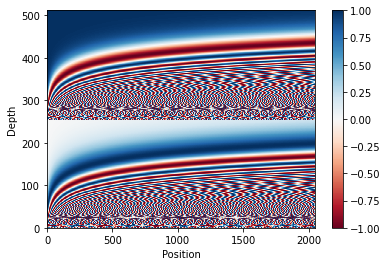

In [29]:
n, d = 2048, 512
pos_encoding = positional_encoding(n, d)
print(pos_encoding.shape)
pos_encoding = pos_encoding[0]

# Juggle the dimensions for the plot
pos_encoding = tf.reshape(pos_encoding, (n, d//2, 2))
pos_encoding = tf.transpose(pos_encoding, (2, 1, 0))
pos_encoding = tf.reshape(pos_encoding, (d, n))

plt.pcolormesh(pos_encoding, cmap='RdBu')
plt.ylabel('Depth')
plt.xlabel('Position')
plt.colorbar()
plt.show()

##Masking

In [30]:
np.vander([1,1,1])

array([[1, 1, 1],
       [1, 1, 1],
       [1, 1, 1]])

In [31]:


def create_enc_padding_mask(seq):
  seq = tf.abs(seq)
  seq = tf.reduce_mean(seq, axis = -1)
  seq = tf.cast(tf.math.equal(seq, 0), tf.float32)
  seq = seq[:, :, tf.newaxis]
  p1 = tf.keras.layers.MaxPooling1D(
    strides=6, padding='same')
  p2 = tf.keras.layers.MaxPooling1D(
    strides=4, padding='same')
  seq = tf.cast(tf.ones(tf.shape(seq)),tf.float32) - seq
  seq = p1(seq)
  seq = p2(seq)
  seq = tf.cast(tf.ones(tf.shape(seq)),tf.float32) - seq
  seq = seq[:,:,0]

  return seq[:, tf.newaxis, tf.newaxis, :]


def create_padding_mask(seq):
  seq = tf.abs(seq)
  #print(seq)
  last = seq.shape[-1]
  seq = tf.reduce_mean(seq, axis = -1)
  seq = tf.cast(tf.math.equal(seq, 0), tf.float32)

  # add extra dimensions to add the padding
  # to the attention logits.
  return seq[:, tf.newaxis, tf.newaxis, :]  # (batch_size, 1, 1, seq_len)

def create_tok_padding_mask(seq):
  seq = tf.cast(tf.math.equal(seq, 0), tf.float32)

  # add extra dimensions to add the padding
  # to the attention logits.
  return seq[:, tf.newaxis, tf.newaxis, :]  # (batch_size, 1, 1, seq_len)

In [32]:
x = tf.constant([[[7, 6, 0, 0, 1], [1, 2, 3, 0, 0], [0, 0, 0, 4, 5]]])
create_padding_mask(x)

<tf.Tensor: shape=(1, 1, 1, 3), dtype=float32, numpy=array([[[[0., 0., 0.]]]], dtype=float32)>

In [33]:
def create_look_ahead_mask(size):
  #print(size)
  mask = 1 - tf.linalg.band_part(tf.ones((size, size)), -1, 0)
  return mask  # (seq_len, seq_len)

In [34]:
inp_sh = (2,12000,129)
x = tf.random.normal(inp_sh)
create_enc_padding_mask(x).shape

TensorShape([2, 1, 1, 500])

In [35]:
ceil(12002/24.0)

501

##Scaled dot product attention

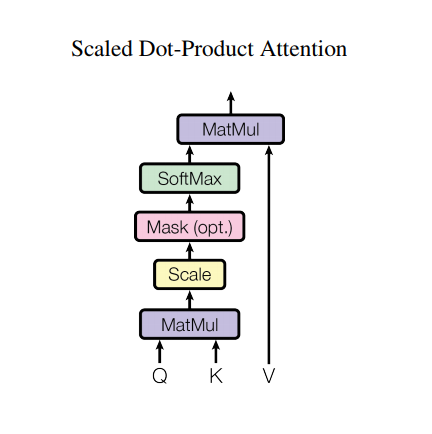

In [36]:
def scaled_dot_product_attention(q, k, v, mask):
  """Calculate the attention weights.
  q, k, v must have matching leading dimensions.
  k, v must have matching penultimate dimension, i.e.: seq_len_k = seq_len_v.
  The mask has different shapes depending on its type(padding or look ahead)
  but it must be broadcastable for addition.

  Args:
    q: query shape == (..., seq_len_q, depth)
    k: key shape == (..., seq_len_k, depth)
    v: value shape == (..., seq_len_v, depth_v)
    mask: Float tensor with shape broadcastable
          to (..., seq_len_q, seq_len_k). Defaults to None.

  Returns:
    output, attention_weights
  """

  #print(type(q))
  #print(type(k))
  matmul_qk = tf.matmul(q, k, transpose_b=True)  # (..., seq_len_q, seq_len_k)

  # scale matmul_qk
  dk = tf.cast(tf.shape(k)[-1], tf.float32)
  scaled_attention_logits = matmul_qk / tf.math.sqrt(dk)

  # add the mask to the scaled tensor.
  if mask is not None:
    scaled_attention_logits += (mask * -1e9)

  # softmax is normalized on the last axis (seq_len_k) so that the scores
  # add up to 1.
  attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1)  # (..., seq_len_q, seq_len_k)

  output = tf.matmul(attention_weights, v)  # (..., seq_len_q, depth_v)

  return output, attention_weights

In [37]:
def print_out(q, k, v):
  temp_out, temp_attn = scaled_dot_product_attention(
      q, k, v, None)
  print('Attention weights are:')
  print(temp_attn)
  print('Output is:')
  print(temp_out)

In [38]:
np.set_printoptions(suppress=True)

temp_k = tf.constant([[10, 0, 0],
                      [0, 10, 0],
                      [0, 0, 10],
                      [0, 0, 10]], dtype=tf.float32)  # (4, 3)

temp_v = tf.constant([[1, 0],
                      [10, 0],
                      [100, 5],
                      [1000, 6]], dtype=tf.float32)  # (4, 2)

# This `query` aligns with the second `key`,
# so the second `value` is returned.
temp_q = tf.constant([[0, 10, 0]], dtype=tf.float32)  # (1, 3)
print_out(temp_q, temp_k, temp_v)

Attention weights are:
tf.Tensor([[0. 1. 0. 0.]], shape=(1, 4), dtype=float32)
Output is:
tf.Tensor([[10.  0.]], shape=(1, 2), dtype=float32)


In [39]:
# This query aligns with a repeated key (third and fourth),
# so all associated values get averaged.
temp_q = tf.constant([[0, 0, 10]], dtype=tf.float32)  # (1, 3)
print_out(temp_q, temp_k, temp_v)

Attention weights are:
tf.Tensor([[0.  0.  0.5 0.5]], shape=(1, 4), dtype=float32)
Output is:
tf.Tensor([[550.    5.5]], shape=(1, 2), dtype=float32)


In [40]:
# This query aligns equally with the first and second key,
# so their values get averaged.
temp_q = tf.constant([[10, 10, 0]], dtype=tf.float32)  # (1, 3)
print_out(temp_q, temp_k, temp_v)

Attention weights are:
tf.Tensor([[0.5 0.5 0.  0. ]], shape=(1, 4), dtype=float32)
Output is:
tf.Tensor([[5.5 0. ]], shape=(1, 2), dtype=float32)


In [41]:
temp_q = tf.constant([[0, 0, 10],
                      [0, 10, 0],
                      [10, 10, 0]], dtype=tf.float32)  # (3, 3)
print_out(temp_q, temp_k, temp_v)

Attention weights are:
tf.Tensor(
[[0.  0.  0.5 0.5]
 [0.  1.  0.  0. ]
 [0.5 0.5 0.  0. ]], shape=(3, 4), dtype=float32)
Output is:
tf.Tensor(
[[550.    5.5]
 [ 10.    0. ]
 [  5.5   0. ]], shape=(3, 2), dtype=float32)


##Multi-Head Attention

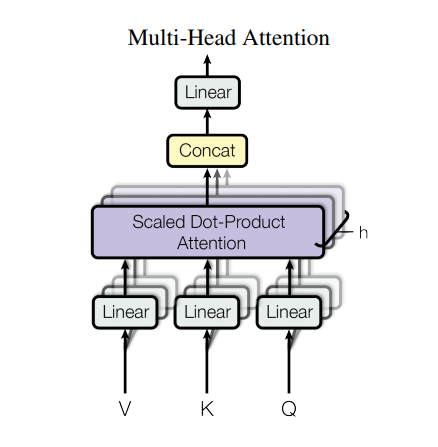

In [42]:
class MultiHeadAttention(tf.keras.layers.Layer):
  def __init__(self, d_model, num_heads):
    super(MultiHeadAttention, self).__init__()
    self.num_heads = num_heads
    self.d_model = d_model

    assert d_model % self.num_heads == 0

    self.depth = d_model // self.num_heads

    self.wq = tf.keras.layers.Dense(d_model)
    self.wk = tf.keras.layers.Dense(d_model)
    self.wv = tf.keras.layers.Dense(d_model)

    self.dense = tf.keras.layers.Dense(d_model)

  def split_heads(self, x, batch_size):
    """Split the last dimension into (num_heads, depth).
    Transpose the result such that the shape is (batch_size, num_heads, seq_len, depth)
    """
    x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
    return tf.transpose(x, perm=[0, 2, 1, 3])

  def call(self, v, k, q, mask):
    batch_size = tf.shape(q)[0]

    q = self.wq(q)  # (batch_size, seq_len, d_model)
    k = self.wk(k)  # (batch_size, seq_len, d_model)
    v = self.wv(v)  # (batch_size, seq_len, d_model)

    q = self.split_heads(q, batch_size)  # (batch_size, num_heads, seq_len_q, depth)
    k = self.split_heads(k, batch_size)  # (batch_size, num_heads, seq_len_k, depth)
    v = self.split_heads(v, batch_size)  # (batch_size, num_heads, seq_len_v, depth)

    # scaled_attention.shape == (batch_size, num_heads, seq_len_q, depth)
    # attention_weights.shape == (batch_size, num_heads, seq_len_q, seq_len_k)
    scaled_attention, attention_weights = scaled_dot_product_attention(
        q, k, v, mask)

    scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])  # (batch_size, seq_len_q, num_heads, depth)

    concat_attention = tf.reshape(scaled_attention,
                                  (batch_size, -1, self.d_model))  # (batch_size, seq_len_q, d_model)

    output = self.dense(concat_attention)  # (batch_size, seq_len_q, d_model)

    return output, attention_weights

In [43]:
temp_mha = MultiHeadAttention(d_model=512, num_heads=8)
y = tf.random.uniform((1, 60, 512))  # (batch_size, encoder_sequence, d_model)
out, attn = temp_mha(y, k=y, q=y, mask=None)
out.shape, attn.shape

(TensorShape([1, 60, 512]), TensorShape([1, 8, 60, 60]))

##Point wise feed forward network

In [44]:
def point_wise_feed_forward_network(d_model, dff):
  return tf.keras.Sequential([
      tf.keras.layers.Dense(dff, activation='relu'),  # (batch_size, seq_len, dff)
      tf.keras.layers.Dense(d_model)  # (batch_size, seq_len, d_model)
  ])

In [45]:
sample_ffn = point_wise_feed_forward_network(512, 2048)
sample_ffn(tf.random.uniform((64, 50, 512))).shape

TensorShape([64, 50, 512])

##Энкодер и декодер

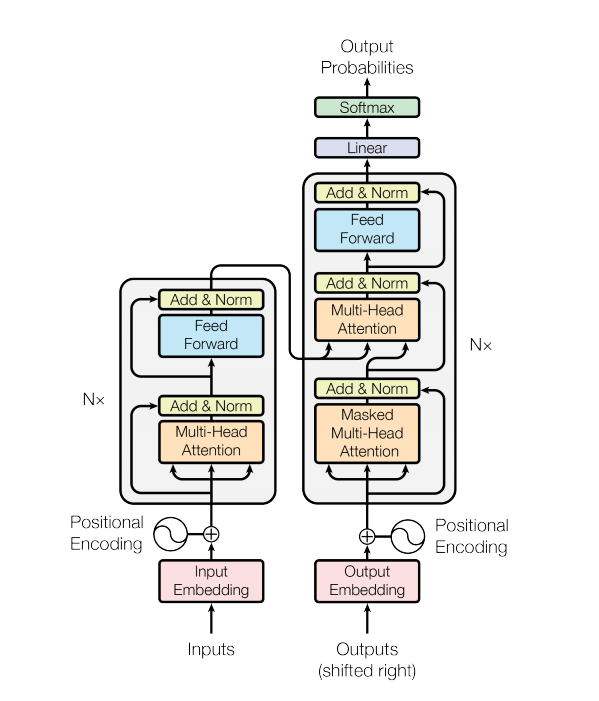

###Энкодер (слой)

In [46]:
class EncoderLayer(tf.keras.layers.Layer):
  def __init__(self, d_model, num_heads, dff, rate=0.1):
    super(EncoderLayer, self).__init__()

    self.mha = MultiHeadAttention(d_model, num_heads)
    self.ffn = point_wise_feed_forward_network(d_model, dff)

    self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

    self.dropout1 = tf.keras.layers.Dropout(rate)
    self.dropout2 = tf.keras.layers.Dropout(rate)

  def call(self, x, training, mask):

    attn_output, _ = self.mha(x, x, x, mask)  # (batch_size, input_seq_len, d_model)
    attn_output = self.dropout1(attn_output, training=training)
    out1 = self.layernorm1(x + attn_output)  # (batch_size, input_seq_len, d_model)

    ffn_output = self.ffn(out1)  # (batch_size, input_seq_len, d_model)
    ffn_output = self.dropout2(ffn_output, training=training)
    out2 = self.layernorm2(out1 + ffn_output)  # (batch_size, input_seq_len, d_model)

    return out2

In [47]:
sample_encoder_layer = EncoderLayer(512, 8, 2048)

sample_encoder_layer_output = sample_encoder_layer(
    tf.random.uniform((64, 43, 512)), False, None)

sample_encoder_layer_output.shape  # (batch_size, input_seq_len, d_model)

TensorShape([64, 43, 512])

In [48]:
sample_encoder_layer = EncoderLayer(512, 8, 2048)

sample_encoder_layer_output = sample_encoder_layer(
    tf.random.uniform((64, 43, 512)), False, None)

sample_encoder_layer_output.shape  # (batch_size, input_seq_len, d_model)

TensorShape([64, 43, 512])

###Декодер (слой)

In [49]:
class DecoderLayer(tf.keras.layers.Layer):
  def __init__(self, d_model, num_heads, dff, rate=0.1):
    super(DecoderLayer, self).__init__()

    self.mha1 = MultiHeadAttention(d_model, num_heads)
    self.mha2 = MultiHeadAttention(d_model, num_heads)

    self.ffn = point_wise_feed_forward_network(d_model, dff)

    self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    self.layernorm3 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

    self.dropout1 = tf.keras.layers.Dropout(rate)
    self.dropout2 = tf.keras.layers.Dropout(rate)
    self.dropout3 = tf.keras.layers.Dropout(rate)

  def call(self, x, enc_output, training,
           look_ahead_mask, padding_mask):
    # enc_output.shape == (batch_size, input_seq_len, d_model)

    attn1, attn_weights_block1 = self.mha1(x, x, x, look_ahead_mask)  # (batch_size, target_seq_len, d_model)
    attn1 = self.dropout1(attn1, training=training)
    out1 = self.layernorm1(attn1 + x)

    attn2, attn_weights_block2 = self.mha2(
        enc_output, enc_output, out1, padding_mask)  # (batch_size, target_seq_len, d_model)
    attn2 = self.dropout2(attn2, training=training)
    out2 = self.layernorm2(attn2 + out1)  # (batch_size, target_seq_len, d_model)

    ffn_output = self.ffn(out2)  # (batch_size, target_seq_len, d_model)
    ffn_output = self.dropout3(ffn_output, training=training)
    out3 = self.layernorm3(ffn_output + out2)  # (batch_size, target_seq_len, d_model)

    return out3, attn_weights_block1, attn_weights_block2

In [50]:
sample_decoder_layer = DecoderLayer(512, 8, 2048)

sample_decoder_layer_output, _, _ = sample_decoder_layer(
    tf.random.uniform((64, 50, 512)), sample_encoder_layer_output,
    False, None, None)

sample_decoder_layer_output.shape  # (batch_size, target_seq_len, d_model)

TensorShape([64, 50, 512])

###Энкодер

In [51]:
class Encoder(tf.keras.layers.Layer):
  def __init__(self, num_layers, d_model, num_heads, dff, furie_size,
               maximum_position_encoding, rate=0.1):
    super(Encoder, self).__init__()

    self.d_model = d_model
    self.num_layers = num_layers
    self.cnn1 = Conv1D(2*d_model,8,strides=6, input_shape=(None,129),padding="same")
    self.cnn2 = Conv1D(d_model,16,strides=4, input_shape=(None,2*d_model),padding="same")
    self.pos_encoding = positional_encoding(maximum_position_encoding,
                                            self.d_model)

    self.enc_layers = [EncoderLayer(d_model, num_heads, dff, rate)
                       for _ in range(num_layers)]

    self.dropout = tf.keras.layers.Dropout(rate)

  def call(self, x, training, mask):

    seq_len = tf.shape(x)[1]

    # adding dence and position encoding.
    #print(x.shape)
    x = self.cnn1(x)
    #print(x.shape)
    x = self.cnn2(x)
    #x = self.cnn3(x)
    x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))

    seq_len = tf.shape(x)[1]
    x += self.pos_encoding[:, :seq_len, :]

    x = self.dropout(x, training=training)
    for i in range(self.num_layers):
      x = self.enc_layers[i](x, training, mask)

    return x  # (batch_size, input_seq_len, d_model)

In [52]:
sample_encoder = Encoder(num_layers=2, d_model=512, num_heads=8,
                         dff=2048, furie_size=129,
                         maximum_position_encoding=10000)
temp_input = tf.random.uniform((2,11980, 129), dtype=tf.float32, minval=0, maxval=200)

#print( tf.shape(temp_input))
x = tf.random.normal((2,11980, 129))
y = tf.keras.layers.Conv1D( 256, 16, input_shape=(None,129), strides=2)(temp_input)
#print(y.shape)


#print(create_enc_padding_mask((2,11980, 129)).shape)


sample_encoder_output = sample_encoder(temp_input, training=False, mask=None)

print(sample_encoder_output.shape)  # (batch_size, input_seq_len, d_model)

(2, 500, 512)


###Декодер

In [53]:
class Decoder(tf.keras.layers.Layer):
  def __init__(self, num_layers, d_model, num_heads, dff, vocab_size,
               maximum_position_encoding, rate=0.1):
    super(Decoder, self).__init__()

    self.d_model = d_model
    self.num_layers = num_layers

    self.embedding = tf.keras.layers.Embedding(vocab_size, d_model)
    self.pos_encoding = positional_encoding(maximum_position_encoding, d_model)

    self.dec_layers = [DecoderLayer(d_model, num_heads, dff, rate)
                       for _ in range(num_layers)]
    self.dropout = tf.keras.layers.Dropout(rate)

  def call(self, x, enc_output, training,
           look_ahead_mask, padding_mask):

    seq_len = tf.shape(x)[1]
    attention_weights = {}

    x = self.embedding(x)  # (batch_size, target_seq_len, d_model)
    x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
    x += self.pos_encoding[:, :seq_len, :]

    x = self.dropout(x, training=training)

    for i in range(self.num_layers):
      x, block1, block2 = self.dec_layers[i](x, enc_output, training,
                                             look_ahead_mask, padding_mask)

      attention_weights[f'decoder_layer{i+1}_block1'] = block1
      attention_weights[f'decoder_layer{i+1}_block2'] = block2

    # x.shape == (batch_size, target_seq_len, d_model)
    return x, attention_weights

In [54]:
sample_decoder = Decoder(num_layers=2, d_model=512, num_heads=8,
                         dff=2048, vocab_size=2045,
                         maximum_position_encoding=5000)
temp_input = tf.random.uniform((1, 157), dtype=tf.int64, minval=0, maxval=200)

output, attn = sample_decoder(temp_input,
                              enc_output=sample_encoder_output,
                              training=False,
                              look_ahead_mask=None,
                              padding_mask=None)

output.shape, attn['decoder_layer2_block2'].shape

(TensorShape([1, 157, 512]), TensorShape([1, 8, 157, 1000]))

##Класс трансформера

In [55]:
class Transformer(tf.keras.Model):
  def __init__(self, num_enc_layers, num_dec_layers, d_model, num_heads, dff, furie_size, vocab_size,
               pe_input, pe_target, rate=0.1, ):
    super().__init__()
    self.encoder = Encoder(num_enc_layers, d_model, num_heads, dff,
                             furie_size, pe_input, rate)

    self.decoder = Decoder(num_dec_layers, d_model, num_heads, dff,
                           vocab_size, pe_target, rate)


    self.final_sm_layer = tf.keras.layers.Dense(vocab_size)#, activation='softmax')

  def call(self, inputs, training):
    # Keras models prefer if you pass all your inputs in the first argument
    inp, tar = inputs
    #print(tar.shape)
    #print(tar)
    #print(tar)
    #print(tar.shape)
    #print(inp.shape)
    enc_padding_mask, look_ahead_mask, dec_padding_mask = self.create_masks(inp, tar)

    

    #print(look_ahead_mask)
    #print(look_ahead_mask)
    #print(enc_padding_mask)
    #print(enc_padding_mask.shape)
    #print("---")


    enc_output = self.encoder(inp, training, enc_padding_mask)  # (batch_size, inp_seq_len, d_model)
    #print(enc_output.shape)
    #dec_padding_mask = tf.constant(np.zeros(enc_output.shape).astype("float32"))
    #print(dec_padding_mask)
    # dec_output.shape == (batch_size, tar_seq_len, d_model)
    dec_output, attention_weights = self.decoder(
        tar, enc_output, training, look_ahead_mask, dec_padding_mask)


    final_output = self.final_sm_layer(dec_output)# (batch_size, tar_seq_len, target_vocab_size)



    return final_output, attention_weights

  def create_masks(self, inp, tar):
    # Encoder padding mask
    enc_padding_mask = create_enc_padding_mask(inp)

    # Used in the 2nd attention block in the decoder.
    # This padding mask is used to mask the encoder outputs.
    #print(inp.shape)
    dec_padding_mask = create_enc_padding_mask(inp)

    # Used in the 1st attention block in the decoder.
    # It is used to pad and mask future tokens in the input received by
    # the decoder.
    #print("---")
    #print(tar.shape)
    #print(tf.shape(tar).numpy())
    look_ahead_mask = create_look_ahead_mask(tf.shape(tar)[1])
    #print(look_ahead_mask.shape)
    dec_target_padding_mask = create_tok_padding_mask(tar)
    look_ahead_mask = tf.maximum(dec_target_padding_mask, look_ahead_mask)

    return enc_padding_mask, look_ahead_mask, dec_padding_mask

In [56]:
for x,y in train_dataset.take(1):
  curr = (x,y)

In [57]:
curr[1]

<tf.Tensor: shape=(2, 1124), dtype=int32, numpy=
array([[   1, 2055, 1842, ...,  124,    3,    2],
       [   1, 2373, 1949, ...,    0,    0,    0]], dtype=int32)>

In [58]:
sample_transformer = Transformer(
    num_enc_layers=2, num_dec_layers=4, d_model=128, num_heads=8, dff=2048,
    furie_size=furie_size, vocab_size=vocab_size,
    pe_input=10000, pe_target=20000)

temp_input = tf.random.uniform((2, 14500, 129), dtype=tf.float32, minval=0.0, maxval=200.0)
temp_target = tf.random.uniform((2, 1045), dtype=tf.int32, minval=0, maxval=vocab_size)

#temp_input = curr[0]
#temp_target = curr[1]

print(temp_input.shape)
print(temp_target.shape)

fn_out, _ = sample_transformer([temp_input, temp_target], training=False)

fn_out  # (batch_size, tar_seq_len, target_vocab_size)

(2, 14500, 129)
(2, 1045)


<tf.Tensor: shape=(2, 1045, 2791), dtype=float32, numpy=
array([[[ 0.67359287, -0.04810744, -0.23596217, ..., -0.24169515,
          0.41505083, -0.29068416],
        [ 0.6541334 , -0.04904212, -0.25687638, ..., -0.23997134,
          0.38244244, -0.321648  ],
        [ 0.66217023, -0.01686211, -0.25050345, ..., -0.23493345,
          0.39312443, -0.31871933],
        ...,
        [ 0.6787318 , -0.09290846, -0.16204308, ..., -0.29841113,
          0.29490042, -0.10145508],
        [ 0.68100876, -0.05438419, -0.16227901, ..., -0.2500459 ,
          0.3201817 , -0.08843385],
        [ 0.6809144 , -0.08277639, -0.20398054, ..., -0.26106095,
          0.29088628, -0.11085539]],

       [[ 0.60789156, -0.06653912, -0.3675441 , ...,  0.11408812,
          0.31232527, -0.2832254 ],
        [ 0.59471816, -0.04853475, -0.34617645, ...,  0.07827246,
          0.27040285, -0.27066624],
        [ 0.61089826, -0.04965874, -0.38649124, ...,  0.07166655,
          0.27772534, -0.30175486],
        ..

##Оптимизатор

In [59]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
  def __init__(self, d_model, warmup_steps=4000):
    super(CustomSchedule, self).__init__()

    self.d_model = d_model
    self.d_model = tf.cast(self.d_model, tf.float32)

    self.warmup_steps = warmup_steps

  def __call__(self, step):
    arg1 = tf.math.rsqrt(step)
    arg2 = step * (self.warmup_steps ** -1.5)
    return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

In [60]:
learning_rate = CustomSchedule(d_model)

optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98,
                                     epsilon=1e-9)

Text(0.5, 0, 'Train Step')

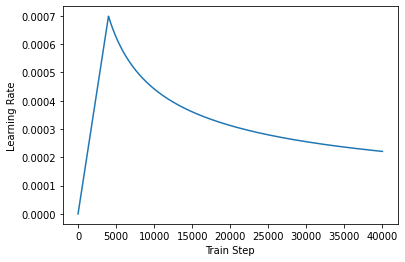

In [61]:
temp_learning_rate_schedule = CustomSchedule(d_model)

plt.plot(temp_learning_rate_schedule(tf.range(40000, dtype=tf.float32)))
plt.ylabel("Learning Rate")
plt.xlabel("Train Step")

##Loss-функция и метрика

In [62]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

In [63]:
for x,y in train_dataset.take(1):
  curr = (x,y)

In [64]:
temp_input = curr[0]
temp_target = curr[1]

print(temp_input.shape)
print(temp_target.shape)

fn_out, _ = sample_transformer([temp_input, temp_target], training=False)

print(fn_out.shape)

print(fn_out[0][0])
print(temp_target[0][5])

loss_object(temp_target, fn_out)

(2, 8160, 129)
(2, 616)
(2, 616, 2791)
tf.Tensor(
[ 0.22234084 -0.26699606 -0.09323726 ... -0.25731382  0.31201166
 -0.09892789], shape=(2791,), dtype=float32)
tf.Tensor(1000, shape=(), dtype=int32)


<tf.Tensor: shape=(2, 616), dtype=float32, numpy=
array([[8.243727 , 8.332349 , 8.203209 , ..., 7.7332582, 7.719078 ,
        7.702813 ],
       [7.931196 , 8.143719 , 7.408939 , ..., 8.041272 , 8.403094 ,
        8.233898 ]], dtype=float32)>

In [65]:

def loss_function(real, pred):
  mask = tf.math.logical_not(tf.math.equal(real, 0))

  loss_ = loss_object(real, pred)
  
  mask = tf.cast(mask, dtype=loss_.dtype)
  loss_ *= mask
  
  return tf.reduce_sum(loss_)/tf.reduce_sum(mask)


def accuracy_function(real, pred):
  #print(tf.argmax(pred, axis=2))
  accuracies = tf.equal(real, tf.cast(tf.argmax(pred, axis=2),tf.int32))

  mask = tf.math.logical_not(tf.math.equal(real, 0))
  accuracies = tf.math.logical_and(mask, accuracies)

  accuracies = tf.cast(accuracies, dtype=tf.float32)
  mask = tf.cast(mask, dtype=tf.float32)
  return tf.reduce_sum(accuracies)/tf.reduce_sum(mask)

In [66]:
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.Mean(name='train_accuracy')

In [67]:
a = tf.constant([[[2,3,4],[3,4,5]]])


#Обучение модели

##Подготовка чекпоинтов

In [68]:
transformer = Transformer(
    num_enc_layers=num_enc_layers,
    num_dec_layers=num_dec_layers,
    d_model=d_model,
    num_heads=num_heads,
    dff=dff,
    furie_size = furie_size,
    vocab_size = vocab_size,
    pe_input=2000,
    pe_target=10000,
    rate=dropout_rate)

In [69]:
last = 0
checkpoint_path = "/content/drive/My Drive/Colab Notebooks/Beat Saber/2Trans/checkpoints/train"# + str(last)
print(checkpoint_path)
ckpt = tf.train.Checkpoint(transformer=transformer,
                           optimizer=optimizer)

ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

# if a checkpoint exists, restore the latest checkpoint.
if ckpt_manager.latest_checkpoint:
  ckpt.restore(ckpt_manager.latest_checkpoint)
  print('Latest checkpoint restored!!')


#ckpt_save_path = ckpt_manager.save()

/content/drive/My Drive/Colab Notebooks/Beat Saber/2Trans/checkpoints/train


In [70]:
EPOCHS = 200

In [71]:
def train_step(inp, tar):
  tar_inp = tar[:, :-1]
  tar_real = tar[:, 1:]
  #print("tf")
  #print(tar_inp.shape)
  #print(tar_real.shape)
  #print(tf.shape(tar_real).numpy())
  with tf.GradientTape() as tape:
    predictions, _ = transformer([inp, tar_inp],
                                 training = True)
    
    loss = loss_function(tar_real, predictions)
  #print(tf.shape(predictions).numpy())
  #print(predictions)
  #print(tar_real)
  #print(predictions.shape)
  print("---")
  #print(tf.shape(tar_real))
  gradients = tape.gradient(loss, transformer.trainable_variables)
  optimizer.apply_gradients(zip(gradients, transformer.trainable_variables))

  train_loss(loss)
  train_accuracy(accuracy_function(tar_real, predictions))

In [72]:
# The @tf.function trace-compiles train_step into a TF graph for faster
# execution. The function specializes to the precise shape of the argument
# tensors. To avoid re-tracing due to the variable sequence lengths or variable
# batch sizes (the last batch is smaller), use input_signature to specify
# more generic shapes.
#(1, 2000, 1025)
#(1, 2000, 4, 3, 37)
train_step_signature = [
    tf.TensorSpec(shape=(BATCH_SIZE, None, furie_size), dtype=tf.float32),
    tf.TensorSpec(shape=(BATCH_SIZE, None), dtype=tf.int32)
]


@tf.function(input_signature=train_step_signature)#, jit_compile = True)
def tf_train_step(inp, tar):

  with tf.GradientTape() as tape:
    predictions, _ = transformer([inp, tar[:, :-1]],
                                 training = True)
    
    loss = loss_function(tar[:, 1:], predictions)
  
  gradients = tape.gradient(loss, transformer.trainable_variables)
  optimizer.apply_gradients(zip(gradients, transformer.trainable_variables))

  train_loss(loss)
  train_accuracy(accuracy_function(tar[:, 1:], predictions))

##Подготовка графиков функции ошибки и метрики

In [73]:
redo = False
#redo = True

if redo:
  name = "/content/drive/My Drive/Colab Notebooks/Beat Saber/2Trans/accuracy.npy"
  np.save(name,np.array([]))
  name = "/content/drive/My Drive/Colab Notebooks/Beat Saber/2Trans/loss.npy"
  np.save(name,np.array([]))
  name = "/content/drive/My Drive/Colab Notebooks/Beat Saber/2Trans/av_accuracy.npy"
  np.save(name,np.array([]))
  name = "/content/drive/My Drive/Colab Notebooks/Beat Saber/2Trans/av_loss.npy"
  np.save(name,np.array([]))
  name = "/content/drive/My Drive/Colab Notebooks/Beat Saber/2Trans/test_accuracy.npy"
  np.save(name,np.array([]))
  name = "/content/drive/My Drive/Colab Notebooks/Beat Saber/2Trans/test_loss.npy"
  np.save(name,np.array([]))

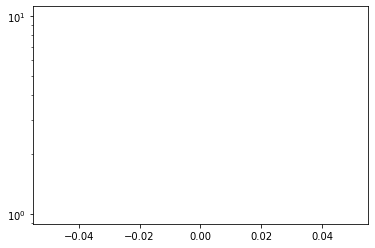

In [74]:
name = "/content/drive/My Drive/Colab Notebooks/Beat Saber/2Trans/av_loss.npy"
loss = np.load(name)
name = "/content/drive/My Drive/Colab Notebooks/Beat Saber/2Trans/test_loss.npy"
t_loss = np.load(name)
#print(loss)
plt.semilogy(loss)
plt.semilogy(t_loss)
plt.show()
#np.save(name,np.array([]))
#name = "/content/drive/My Drive/Colab Notebooks/Mentoring2122/Transformer/FirstVer/accuracy.npy"
#np.save(name,np.array([]))

In [75]:
for x, y in train_dataset.take(1):
      curr = x,y

In [76]:
num = 250
print(create_enc_padding_mask(curr[0])[1][0][0][num:])

tf.Tensor(
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 

In [77]:
print(create_padding_mask(curr[0])[1][0][0][24*num:24*num+96])

tf.Tensor(
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.], shape=(96,), dtype=float32)


##Обучение

In [78]:
BUFFER_SIZE = 270
BATCH_SIZE = 2
tf.executing_eagerly()

song_in_ep = 720
song_in_test = 80

num_fast_ep = 10
length = set([])
train_loss.reset_states()
train_accuracy.reset_states()
for epoch in tqdm(range(EPOCHS)):


  if epoch < num_fast_ep:
    train_loss.reset_states()
    train_accuracy.reset_states()


  start = time.time()

  download_time = []
  learning_time = []

  

  end_download = time.time()

  if (epoch) % 1 == 0:
    pass
    #train_loss.reset_states()
    #train_accuracy.reset_states()

  

  new_loss = []
  new_accur = []
  epoch_loss = []
  epoch_accur = []
  #train_examples = train_dataset.shuffle(BUFFER_SIZE).prefetch(BUFFER_SIZE)
  #val_examples = val_dataset.shuffle(BUFFER_SIZE).prefetch(BUFFER_SIZE)
  curr_batch = 0
  for curr_batch in tqdm(range(song_in_ep)):
    curr_start = time.time()
    curr = g_train()
    for x, y in train_dataset.take(1):
      curr = x,y
    end_download = time.time()
    #print(tar.shape)
    inp, tar = curr
    
    tf_train_step(inp, tar)

    
    new_loss = new_loss + [float(train_loss.result())]
    new_accur = new_accur + [float(train_accuracy.result())]
    epoch_loss = epoch_loss + [float(train_loss.result())]
    epoch_accur = epoch_accur + [float(train_accuracy.result())]
    if curr_batch % 10 == 0:
      print(f'Epoch {epoch + 1} Batch {curr_batch} Loss {train_loss.result():.4f} Accuracy {train_accuracy.result():.4f}')

      name = "/content/drive/My Drive/Colab Notebooks/Beat Saber/FirstTrans/loss.npy"
      full_loss = np.load(name)
      full_loss = np.array(full_loss.tolist()+new_loss)
      np.save(name,full_loss)
      #print(full_loss)
      new_loss = []
      name = "/content/drive/My Drive/Colab Notebooks/Beat Saber/FirstTrans/accuracy.npy"
      full_accur = np.load(name)
      full_accur = np.array(full_accur.tolist()+new_accur)
      np.save(name,full_accur)
      new_accur = []
    
    if ((curr_batch % 300 == 0) and (curr_batch!=0)):
      ckpt_save_path = ckpt_manager.save()
      print("---")
      print(f'Saving checkpoint for batch {curr_batch} at {ckpt_save_path}')
      print("---")

    end_learning = time.time()
    #end_download = time.time()
    download_time.append(end_download-curr_start)
    learning_time.append(end_learning-end_download)
    #print(f'--- {download_time[-1]:.4f} -- {learning_time[-1]:.4f} ---')
    #curr_batch+=1


  
  
  if (epoch + 1) % 1 == 0:
    name = "/content/drive/My Drive/Colab Notebooks/Beat Saber/FirstTrans/av_loss.npy"
    full_loss = np.load(name)
    full_loss = full_loss.tolist()+[np.array(epoch_loss).mean()]
    np.save(name,np.array(full_loss))
    name = "/content/drive/My Drive/Colab Notebooks/Beat Saber/FirstTrans/av_accuracy.npy"
    full_accur = np.load(name)
    full_accur = full_accur.tolist() + [np.array(epoch_accur).mean()]
    np.save(name,full_accur)
    #checkpoint_path = "/content/drive/My Drive/Colab Notebooks/Beat Saber/FirstTrans/checkpoints/train" + str(epoch)
    #ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)
    ckpt_save_path = ckpt_manager.save()
    print(f'Saving checkpoint for epoch {epoch+1} at {ckpt_save_path}')


  test_loss = []
  test_accur = []
  for i in range(song_in_test):
    for x,y in val_dataset.take(1):
      curr = (x,y)

    song = curr[0]
    level_inp = curr[1][:, :-1]
    level_real = curr[1][:, 1:]

    #print(song.shape)
    #print(level_inp.shape)
    #print(level_real.shape)

    fn_out, _ = transformer([song, level_inp], training=False)

    test_loss.append(loss_function(level_real, fn_out).numpy())
    test_accur.append(accuracy_function(level_real, fn_out).numpy())
  test_loss = np.array(test_loss).mean()
  test_accur = np.array(test_accur).mean()
  name = "/content/drive/My Drive/Colab Notebooks/Beat Saber/FirstTrans/test_loss.npy"
  full_loss = np.load(name)
  full_loss = full_loss.tolist()+[float(test_loss)]
  np.save(name,np.array(full_loss))
  name = "/content/drive/My Drive/Colab Notebooks/Beat Saber/FirstTrans/test_accuracy.npy"
  full_accur = np.load(name)
  full_accur = full_accur.tolist()+[float(test_accur)]
  np.save(name,np.array(full_accur))


  print(f'Epoch {epoch + 1} Train Loss {train_loss.result():.4f} Train Accuracy {train_accuracy.result():.4f}')
  print(f'Epoch {epoch + 1}  Test Loss {test_loss:.4f}  Test Accuracy {test_accur:.4f}')

  download_time = np.array(download_time).sum()
  learning_time = np.array(learning_time).sum()
  print(f'Time taken for 1 epoch: {download_time:.2f} + {learning_time:.2f}')

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/720 [00:00<?, ?it/s]

Epoch 1 Batch 0 Loss 8.0874 Accuracy 0.0008
Epoch 1 Batch 10 Loss 8.0956 Accuracy 0.0005
Epoch 1 Batch 20 Loss 8.0879 Accuracy 0.0006
Epoch 1 Batch 30 Loss 8.0660 Accuracy 0.0010
Epoch 1 Batch 40 Loss 8.0442 Accuracy 0.0010
Epoch 1 Batch 50 Loss 8.0180 Accuracy 0.0013
Epoch 1 Batch 60 Loss 7.9964 Accuracy 0.0016
Epoch 1 Batch 70 Loss 7.9733 Accuracy 0.0023
Epoch 1 Batch 80 Loss 7.9564 Accuracy 0.0027
Epoch 1 Batch 90 Loss 7.9386 Accuracy 0.0028
Epoch 1 Batch 100 Loss 7.9213 Accuracy 0.0033
Epoch 1 Batch 110 Loss 7.9037 Accuracy 0.0041
Epoch 1 Batch 120 Loss 7.8863 Accuracy 0.0048
Epoch 1 Batch 130 Loss 7.8684 Accuracy 0.0049
Epoch 1 Batch 140 Loss 7.8519 Accuracy 0.0050
Epoch 1 Batch 150 Loss 7.8360 Accuracy 0.0051
Epoch 1 Batch 160 Loss 7.8238 Accuracy 0.0050
Epoch 1 Batch 170 Loss 7.8094 Accuracy 0.0052
Epoch 1 Batch 180 Loss 7.7950 Accuracy 0.0056
Epoch 1 Batch 190 Loss 7.7806 Accuracy 0.0058
Epoch 1 Batch 200 Loss 7.7690 Accuracy 0.0058
Epoch 1 Batch 210 Loss 7.7558 Accuracy 0.0062

  0%|          | 0/720 [00:00<?, ?it/s]

Epoch 2 Batch 0 Loss 7.4106 Accuracy 0.0084
Epoch 2 Batch 10 Loss 7.3817 Accuracy 0.0094
Epoch 2 Batch 20 Loss 7.3745 Accuracy 0.0086
Epoch 2 Batch 30 Loss 7.3807 Accuracy 0.0084
Epoch 2 Batch 40 Loss 7.3764 Accuracy 0.0074
Epoch 2 Batch 50 Loss 7.3751 Accuracy 0.0077
Epoch 2 Batch 60 Loss 7.3790 Accuracy 0.0078
Epoch 2 Batch 70 Loss 7.4031 Accuracy 0.0078
Epoch 2 Batch 80 Loss 7.3982 Accuracy 0.0077
Epoch 2 Batch 90 Loss 7.3980 Accuracy 0.0074
Epoch 2 Batch 100 Loss 7.4016 Accuracy 0.0071
Epoch 2 Batch 110 Loss 7.3956 Accuracy 0.0069
Epoch 2 Batch 120 Loss 7.3907 Accuracy 0.0068
Epoch 2 Batch 130 Loss 7.3897 Accuracy 0.0071
Epoch 2 Batch 140 Loss 7.3913 Accuracy 0.0073
Epoch 2 Batch 150 Loss 7.3859 Accuracy 0.0074
Epoch 2 Batch 160 Loss 7.3863 Accuracy 0.0075
Epoch 2 Batch 170 Loss 7.3850 Accuracy 0.0075
Epoch 2 Batch 180 Loss 7.3882 Accuracy 0.0074
Epoch 2 Batch 190 Loss 7.3875 Accuracy 0.0078
Epoch 2 Batch 200 Loss 7.3855 Accuracy 0.0078
Epoch 2 Batch 210 Loss 7.3863 Accuracy 0.0078

ResourceExhaustedError: ignored

#Модель генератора

##Создание модуля

In [ ]:
class Generator(tf.Module):
  def __init__(self, transformer):
    self.transformer = transformer

  def __call__(self, sentence, max_length=2000):
    # input sentence is portuguese, hence adding the start and end token
    assert isinstance(sentence, tf.Tensor)
    if len(sentence.shape) == 0:
      sentence = sentence[tf.newaxis]
    #print(sentence)
    #sentence = rus_tokenize(sentence)
    #print(sentence)

    encoder_input = sentence

    # as the target is english, the first token to the transformer should be the
    # english start token.
    start_end = tf.cast([1,2],tf.int32)
    start = tf.cast(start_end[0][tf.newaxis],tf.int32)
    #print(start_end)
    end = tf.cast(start_end[1][tf.newaxis],tf.int32)
    #print(start)
    #print(end)
    

    # `tf.TensorArray` is required here (instead of a python list) so that the
    # dynamic-loop can be traced by `tf.function`.
    output_array = tf.TensorArray(dtype=tf.int32, size=0, dynamic_size=True)
    output_array = output_array.write(0, start)

    for i in tqdm(tf.range(max_length)):
      output = tf.transpose(output_array.stack())
      print(output.shape)
      predictions, _ = self.transformer([encoder_input, output], training=False)
      #print(output)
      # select the last token from the seq_len dimension
      predictions = predictions[:, -1:, :]  # (batch_size, 1, vocab_size)

      predicted_id = tf.cast(tf.argmax(predictions, axis=-1),tf.int32)

      # concatentate the predicted_id to the output which is given to the decoder
      # as its input.
      output_array = output_array.write(i+1, predicted_id[0])
      #print(predicted_id[0])
      #print(end)
      if predicted_id[0] == end:
        break
    #print(output_array.stack())
    output = tf.transpose(output_array.stack())
    # output.shape (1, tokens)
    
    #text = en_detokenize(output)[0]  # shape: ()

    text = output
    tokens = output

    # `tf.function` prevents us from using the attention_weights that were
    # calculated on the last iteration of the loop. So recalculate them outside
    # the loop.
    _, attention_weights = self.transformer([encoder_input, output[:,:-1]], training=False)

    return text, tokens, attention_weights

In [ ]:
#num = 0
#checkpoint_path = "/content/drive/My Drive/Colab Notebooks/Mentoring2122/Transformer/FirstRus/checkpoints/train" + str(num)
#ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

if ckpt_manager.latest_checkpoint:
  ckpt.restore(ckpt_manager.latest_checkpoint)
  print('Latest checkpoint restored!!')


Latest checkpoint restored!!


In [ ]:
translator = Generator(transformer)

In [ ]:
def print_translation(song, tokens, true_tokens):
  print(f'{"Input:":15s}: {song.shape}')
  print(f'{"Prediction":15s}: {tokens.shape}')
  print(f'{"Ground truth":15s}: {true_tokens.shape}')

## Проверка на тестовой выборке

In [ ]:
for x,y in train_dataset.batch(1).take(1):
  curr = (x,y)


song = curr[0]
print(song[:100])
ground_truth = curr[1]
print(ground_truth.shape)

generated_tokens, translated_tokens, attention_weights = translator(
    tf.constant(song))
print_translation(song, generated_tokens, ground_truth)
print(generated_tokens)
print(ground_truth[0][:100])
print(ground_truth[0][-100:])
print("Loss:" + str(loss_function(ground_truth, generated_tokens)))
print("Accuracy:" + str(accuracy_function(ground_truth, generated_tokens)))

tf.Tensor(
[[[0.01144409 0.00997162 0.00669479 ... 0.00004452 0.00005734 0.00006264]
  [0.0024147  0.00203514 0.008461   ... 0.00024235 0.0003047  0.00002599]
  [0.00387764 0.00418854 0.00413132 ... 0.00048423 0.00040293 0.00038433]
  ...
  [0.00299072 0.0102005  0.00764847 ... 0.00002474 0.00002259 0.00002283]
  [0.01127625 0.01048279 0.00715256 ... 0.00000358 0.0000053  0.0000056 ]
  [0.00018525 0.00018966 0.00018764 ... 0.00000149 0.00000155 0.00000155]]], shape=(1, 581, 4097), dtype=float32)
(1, 930)


  0%|          | 0/2000 [00:00<?, ?it/s]

(1, 1)
(1, 2)
(1, 3)
(1, 4)
(1, 5)
(1, 6)
(1, 7)
(1, 8)
(1, 9)
Input:         : (1, 581, 4097)
Prediction     : (1, 10)
Ground truth   : (1, 930)
tf.Tensor([[   1 1082  996  976  639  909  647  694  237    2]], shape=(1, 10), dtype=int32)
tf.Tensor(
[   1 1082 1089 1083 1091 1085 1094 1124  647 1156  647 1204  824 1111
  824 1117  647 1122  647 1107  824  866  824 1138  647 1100  647 1116
  824 1177  639 1116  651 1185  647 1089 1201  568  934  576  839 1252
  730 1273  730  524  989 1252  885  537  883  671  899  506 1098  521
  886  539  880  355  539 1112  668  902  281 1351 1273  862  161  989
  856  696  521  672  894  506 1098  524  886  521  557  537  893  539
  873  536  923  524  697 1252  862 1252  885  537  883  537  987 1273
 1138  853], shape=(100,), dtype=int32)
tf.Tensor(
[ 661 1156    6  754  756 1217 1111  387  341 1136   16  647 1116  853
 1324 1217  740 1230  740  853  868  460  743  756    7  531  887  452
 1305  574  743  839  354  541 1100  509  510 1089  862  529

ValueError: ignored

In [ ]:
for x,y in train_dataset.batch(1).take(1):
  curr = (x,y)

temp_input = curr[0]
temp_target = curr[1]

print(temp_input.shape)
print(temp_target.shape)

fn_out, _ = transformer([temp_input, temp_target[:,:-1]], training=False)
print(fn_out.shape)
print("Loss: " + str(loss_function(temp_target[:,1:], fn_out).numpy()))
print("Accuracy:" + str(accuracy_function(temp_target[:,1:], fn_out).numpy()))

(1, 425, 4097)
(1, 619)
(1, 618, 1352)
Loss: 1.3384328
Accuracy:0.5873786


In [ ]:
fn_out[:,0:10]

<tf.Tensor: shape=(1, 10, 1352), dtype=float32, numpy=
array([[[-15.567731  , -15.3145075 ,   1.9852694 , ...,  -7.2967114 ,
          -5.4006896 ,  -0.953487  ],
        [-10.733083  , -10.07539   ,   0.46565083, ...,  -2.400626  ,
          -1.9387844 ,   0.43920174],
        [-13.077424  , -12.53686   ,  -1.0339416 , ...,  -6.522777  ,
          -3.2753851 ,  -1.9174031 ],
        ...,
        [-16.091028  , -15.279721  ,  -0.83608705, ...,  -4.7133904 ,
          -6.4179254 ,  -1.5859092 ],
        [-13.597374  , -12.963159  ,  -2.421246  , ...,  -5.3766503 ,
          -7.294643  ,   2.659827  ],
        [-14.493584  , -13.785846  ,  -0.3550934 , ...,  -4.3652573 ,
          -5.015204  ,  -2.1462278 ]]], dtype=float32)>